In [61]:
import networkx as nx
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from random_network import *
from bba import *

In [69]:
G = Random(N=1000, 
               fm=0.5, 
               d=0.01,
               verbose=False)

In [57]:
aG = DPA(N=1000, 
        fm=0.5, 
        d=0.01, 
        plo_M=2.5, 
        plo_m=2.5,
        verbose=False)

In [62]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.histplot(degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


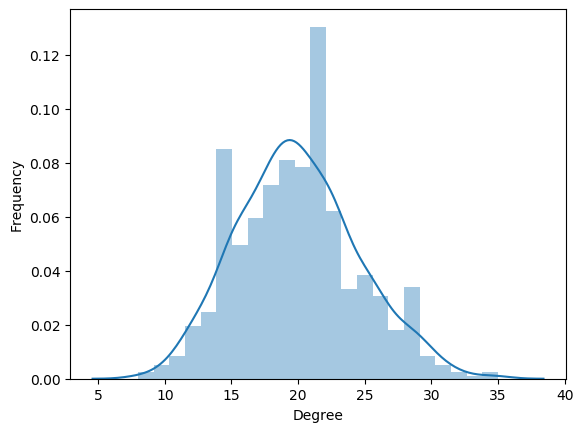

In [70]:
plot_degree_dist(G)

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


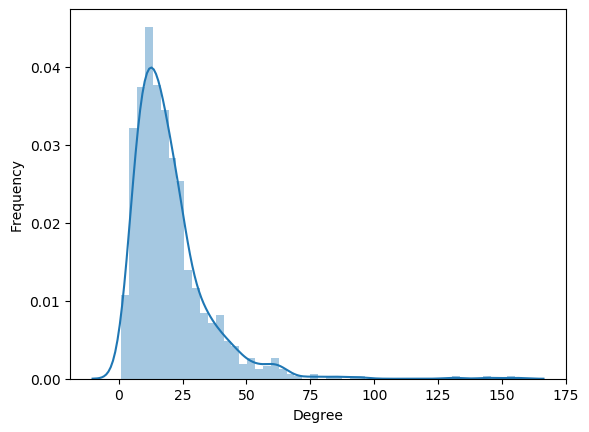

In [64]:
plot_degree_dist(aG)

In [67]:
def plot_degree_dist_per_group(G):
    male_degrees = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1]['gender'] == 0]
    female_degrees = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1]['gender'] == 1]
    
    plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
    plt.hist(male_degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.title('Male')
    plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
    plt.hist(female_degrees)
    plt.xlabel('Degree')
    plt.title('Female')

    plt.show()

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


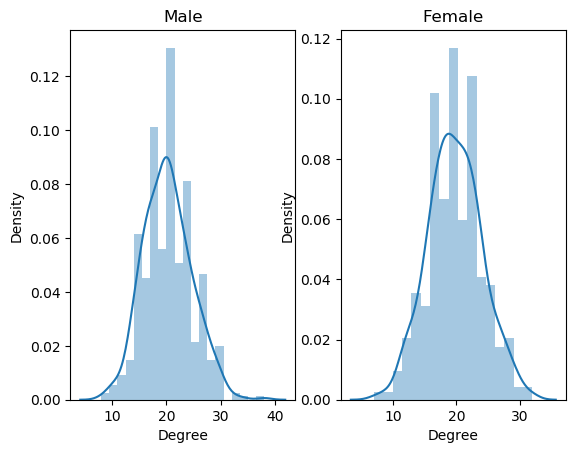

In [68]:
plot_degree_dist_per_group(G)